In [1]:
import sys

sys.path.append('/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis_MAINBRANCH/IPNAnalysis')


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import helper_functions as helper


spike_times = np.load('/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis_MAINBRANCH/AnalyzedData/CDKL5_R59X_10112024_PS_ks4/CDKL5_R59X_10112024_PS/241025/M08020/Network/000128/well002/spikesorted_spike_times_dict.npy',allow_pickle=True).item()



dict_keys(['prominences', 'left_bases', 'right_bases'])


(0.0, 60.0)

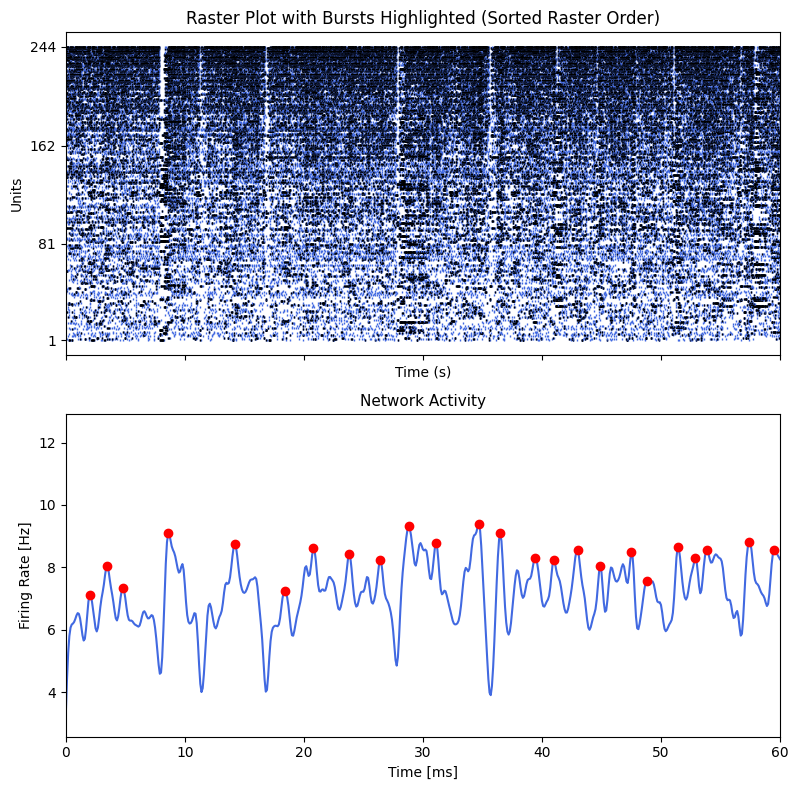

In [3]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8),sharex=True)
# Define the ISI threshold for burst detection (e.g., 0.1 seconds)
isi_threshold = 0.1
# Detect bursts for each unit
burst_statistics = helper.detect_bursts_statistics(spike_times, isi_threshold)
bursts = [unit_stats['bursts'] for unit_stats in burst_statistics.values()]
# Extracting ISIs as combined arrays
all_isis_within_bursts = np.concatenate([stats['isis_within_bursts'] for stats in burst_statistics.values() if stats['isis_within_bursts'].size > 0])
all_isis_outside_bursts = np.concatenate([stats['isis_outside_bursts'] for stats in burst_statistics.values() if stats['isis_outside_bursts'].size > 0])
all_isis = np.concatenate([stats['isis_all'] for stats in burst_statistics.values() if stats['isis_all'].size > 0])

# Calculate combined statistics
mean_isi_within_combined = np.mean(all_isis_within_bursts) if all_isis_within_bursts.size > 0 else np.nan
cov_isi_within_combined = np.cov(all_isis_within_bursts) if all_isis_within_bursts.size > 0 else np.nan

mean_isi_outside_combined = np.mean(all_isis_outside_bursts) if all_isis_outside_bursts.size > 0 else np.nan
cov_isi_outside_combined = np.cov(all_isis_outside_bursts) if all_isis_outside_bursts.size > 0 else np.nan

mean_isi_all_combined = np.mean(all_isis) if all_isis.size > 0 else np.nan
cov_isi_all_combined = np.cov(all_isis) if all_isis.size > 0 else np.nan

# Calculate spike counts for each unit
spike_counts = {unit: len(times) for unit, times in spike_times.items()}

# Sort units by ascending spike counts
sorted_units = sorted(spike_counts, key=spike_counts.get)

axs[0]= helper.plot_raster_with_bursts(axs[0],spike_times, bursts,sorted_units=sorted_units, title_suffix="(Sorted Raster Order)")

# Call the plot_network_activity function and pass the SpikeTimes dictionary
axs[1],network_data= helper.plot_network_activity(axs[1],spike_times, figSize=(8, 4),binSize=0.1, gaussianSigma=0.2,min_peak_distance=10, thresholdBurst=2)


plt.tight_layout()
plt.xlim(0, 60)

(0.0, 60.0)

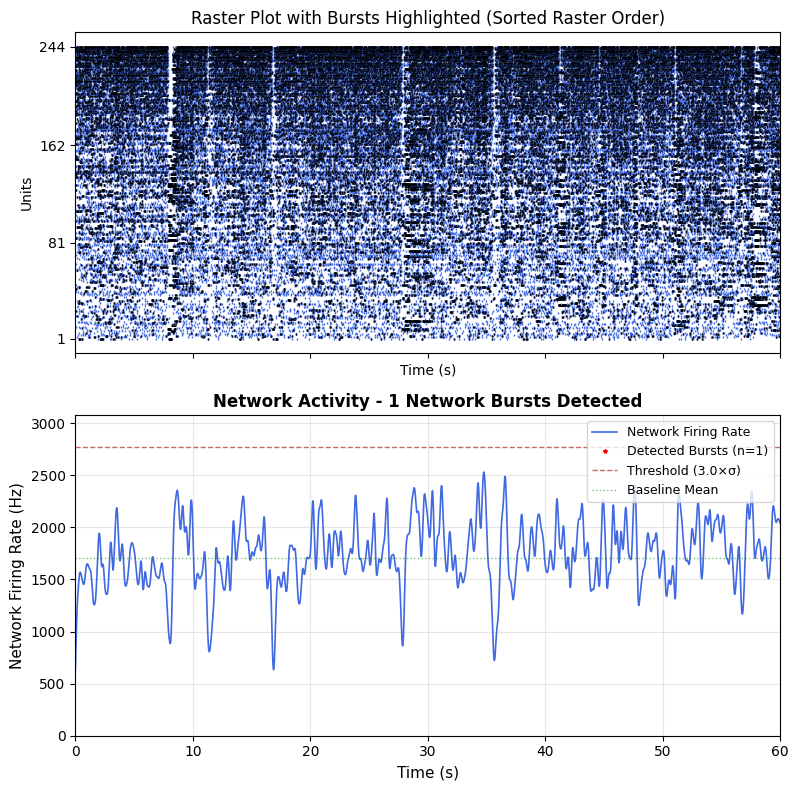

In [4]:
from gaussianNetworkBursts import plot_network_activity as pna_gaussian
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

isi_threshold = 0.1
burst_statistics = helper.detect_bursts_statistics(spike_times, isi_threshold)
bursts = [unit_stats['bursts'] for unit_stats in burst_statistics.values()]

spike_counts = {unit: len(times) for unit, times in spike_times.items()}
sorted_units = sorted(spike_counts, key=spike_counts.get)

# Raster panel (unchanged)
helper.plot_raster_with_bursts(
    axs[0],
    spike_times,
    bursts,
    sorted_units=sorted_units,
    title_suffix="(Sorted Raster Order)"
)

# NEW: use your improved Gaussian-based network activity function
network_data = pna_gaussian(
    axs[1],
    spike_times,
    binSize=0.01,          # finer bins
    gaussianSigma=0.1,     # 100 ms
    thresholdBurst=3.0,
    min_peak_distance=1.0,
    min_active_threshold=0.1
)

plt.tight_layout()
axs[1].set_xlim(0, 60)    # or derive from network_data if you want

(8.0, 18.0)

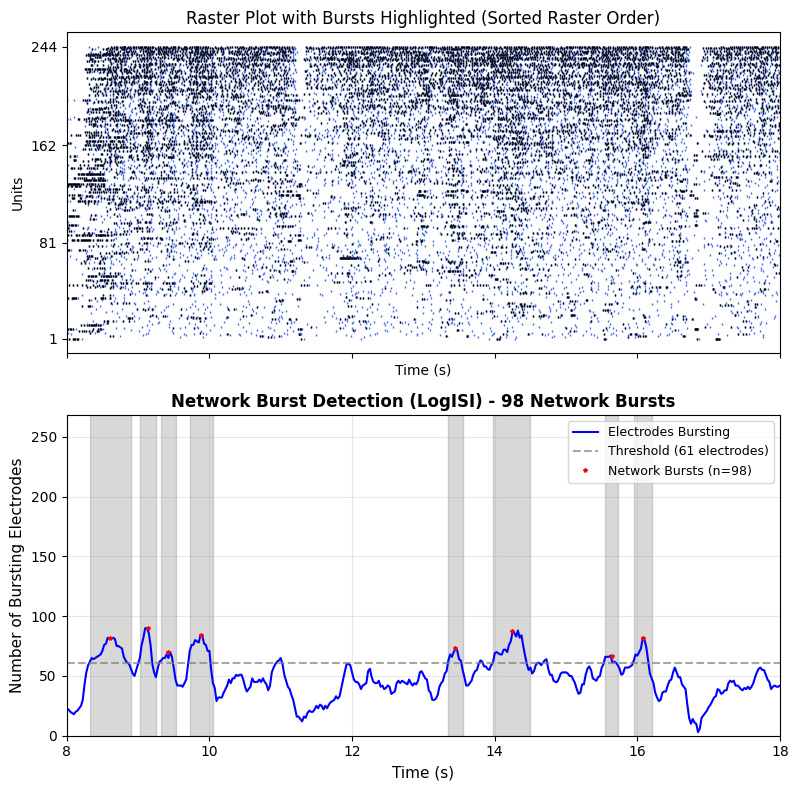

In [5]:
from logISINetworkBurst import plot_network_bursts_logISI  as pna_logISI
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# still fine to use your old per-unit burst stats for raster,
# OR you can eventually swap to per-unit logISI (below in section 3)
isi_threshold = 0.1
burst_statistics = helper.detect_bursts_statistics(spike_times, isi_threshold)
bursts = [unit_stats['bursts'] for unit_stats in burst_statistics.values()]

spike_counts = {unit: len(times) for unit, times in spike_times.items()}
sorted_units = sorted(spike_counts, key=spike_counts.get)

helper.plot_raster_with_bursts(
    axs[0],
    spike_times,
    bursts,
    sorted_units=sorted_units,
    title_suffix="(Sorted Raster Order)"
)

# NEW: LogISI-based network bursts
network_data_logisi = pna_logISI(
    axs[1],
    spike_times,
    max_isi_cutoff=0.1,
    void_threshold=0.7,
    min_spikes_in_burst=3,
    min_active_electrodes=0.25,      # 25% of active electrodes
    time_window=0.05,                # 50 ms window
    min_active_threshold=0.1         # Hz
)

plt.tight_layout()
axs[1].set_xlim(8, 18)